In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
from patchify import patchify
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random
from keras.models import Sequential
from keras.layers import Conv2D
import os
from PIL import Image

scaler = MinMaxScaler()
root_directory = 'segm_data/'
SIZE = 256
image_dataset = []  
mask_dataset = []

2023-10-29 16:49:24.508432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 16:49:24.821190: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-29 16:49:24.874878: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hanrewan/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/home/hanrewan/

In [2]:
for path, subdirs, files in os.walk(root_directory): 
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        for u in range(1, 10):  
            image_name = f'image_part_00{u}.jpg'

            img = cv2.imread(path+"/"+image_name, cv2.IMREAD_COLOR)       
            img = cv2.resize(img, (SIZE, SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            image_dataset.append(img)
            
    if dirname == 'masks':
        masks = os.listdir(path) 
        for u in range(1, 10):
            mask_name = f'image_part_00{u}.png'
            mask = cv2.imread(path+"/"+mask_name, 0)       
            mask = cv2.resize(mask, (SIZE, SIZE))
            mask_dataset.append(mask)
                 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [3]:
mask_dataset = np.array(mask_dataset)

X_train = image_dataset
y_train = mask_dataset
y_train = np.expand_dims(y_train, axis=3)

In [4]:
activation = 'sigmoid'
feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (256, 256, 3)))
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))

2023-10-29 16:49:29.100690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-29 16:49:29.100855: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hanrewan/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/home/hanrewan/anaconda3/lib/:/home/hanrewan/anaconda3/lib/python3.8/site-packages/tensorrt/:/home/hanrewan/anaconda3/envs/tf/lib:/home/hanrewan/anaconda3/envs/tf/lib/python3.8/site-packages/tensorrt/
2023-10-29 16:49:29.101062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file 

In [5]:
X = feature_extractor.predict(X_train)

3/3 [==============================] - 0s 92ms/step


In [6]:
X = X.reshape(-1, X.shape[3])

Y = y_train.reshape(-1)

dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

[ 91  44 172 161 164 171 154  72  79  59 124 127  62  52  51  98 155 146
  56  57  64 125 133  54 159  78  68  83  47 160  76 130  94  96 117 162
  82  77 139 149 150  81  50 101 167  87  95  48  63 138 129  45 119 120
 148 165  84 152 169 105 153 110 104 113 132 144  65 131 108 123  69 102
 107 118 151 140 147  93 168  58  97 103 115 137 142 111  61  89 156  90
  70 128  60  73  80  55 157 122  75  92 134 135 100  99 126  46 158 109
 112  53  49 106 121 163 136 145 166 143  85  86  88 170 116 114 141  67
  71 196 212 207 178 186 190 200 185 211 191 182  66 174 187 176 204 202
 208 194 173 195 210  74 184 205 177 201 199 181 175 179 203 192 188 180
 198 206 193 189 209 183 197   0  43  27  28   9   3  36  20  23  17  41
  29  34   4   6   7   2  37  10  12   1   8  30  32  14  16  25  24  33
  31  22   5  39  15  42  11  38  35  13  40  19  21  18  26 221 213 215
 214 219 218 216 217 220]
Label
91     1663597
171     878616
119     492710
212     377584
66      299388
        ...   
27

In [7]:
dataset = dataset[dataset['Label'] != 0]

X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']

In [17]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, max_depth=20, random_state = 42)

In [18]:
model.fit(X_for_RF, Y_for_RF)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

In [19]:
filename = 'RF_model.sav'
#pickle.dump(model, open(filename, 'wb'))

In [11]:
loaded_model = pickle.load(open(filename, 'rb'))

In [13]:
test_img = cv2.imread('segm_data/Tile 8/images/image_part_001.jpg', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE, SIZE))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)

1/1 [==============================] - 0s 17ms/step


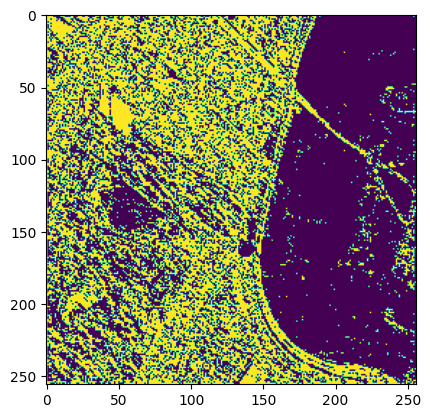

In [15]:
test_img = np.expand_dims(test_img, axis=0)
X_test_feature = feature_extractor.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

prediction = loaded_model.predict(X_test_feature)

prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image)